## Context

A long time ago a previous machine learning engineer delivered a container that<br>
serves a model for inference. Unfortunately the source code and documentation<br>
was lost. We only know the following things:<br>

• The container is available on Docker hub at resnap/assignment:latest.<br>
You can run it on port 8000 with `docker run -p 8000:8000 resnap/assignment:latest`<br>

• The container serves a simple HTTP API: Using curl, a request can<br>
be made with `curl -X POST -H "content-type: application/json" -d '{"numbers": [1,2,3]}' http://localhost:8000` <br>
if the container is running.<br>

• To reduce container size, the model is downloaded on container startup.<br>

### __Question 1__

Run the container on your local machine, and write a Python script to make some requests to the container.<br>
Please provide:<br>
1. The code you use to make requests to the container<br>
2. After a few requests, what do you think the model does? Which inputs did you try and why?<br>

In [12]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# The container serves a HTTP API at http://localhost:8000
# Using the requests library it is possible to communicate with the API by making HTTP requests.
# The API can be used to infer from a model.
# Using the POST method it is possible to provide the model with an input, given through the "json" parameter,
#   and to receive the corresponding output.
# The output is available accessing the attribute "text" of the Response object, in str type.
# The .json() method returns a JSON object of the result or, as in our case, a list.


url = 'http://localhost:8000'
numbers = list(np.linspace(-1,4, num=20))
myobj = {'numbers': numbers}

x = requests.post(url, json = myobj)

# A DataFrame with 2 columns is created: 
#   the "input" column is used to store the numbers given as input to the model,
#   while the "output" column in used to store the output of the model.

df = pd.DataFrame(myobj).rename({"numbers":"input"}, axis = 1)
df["output"] = pd.Series(x.json())
df.head()


,input,output
0,-1.000000,0.000000
1,-0.736842,0.000000
2,-0.473684,0.000000
3,-0.210526,0.000000
4,0.052632,0.105263


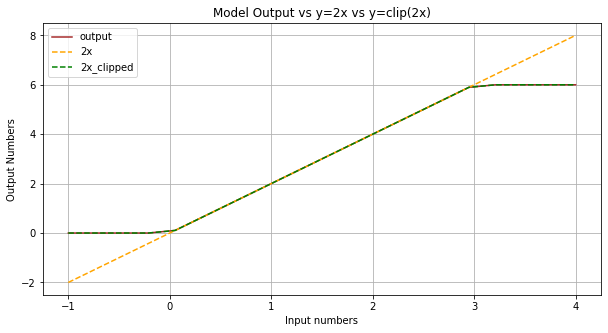

In [14]:
# In order to investigate the behavior of the model, its outputs have been analyzed
#   while giving different inputs (input-output analysis).
# Specifically, the inputs tested are:
#   1) [1,2,3]
#   2) range(20)                            --> to understand the lenght if the input
#   3) [[1.,2.,3.],[1.,2.,3.]]              --> to understand what dimensionality of the input was accepted by the model
#   4) list(np.linspace(-10,10, num=100))   --> to understand the behavior with neg numbers
#   5) list(np.linspace(-1,4, num=100))     --> to understand the smoothness around the point at (0,0) and at (3,6)

# Using the same numbers previously given to the model,
#   2 fuctions, with a similar behavior, are calculated and plotted against the model output.

# The 2 functions were chosen intuitively drawing conclusions from the previous I/O analysis. 
# The 2 fuctions are:
#   y = 2x 
#   y = clip(2x)

# This is done in order to visually show that the behavior of the model consists in applying to the inputs the
#   function y = clip(2x)


df["2x"] = 2*df.input
df["2x_clipped"] = np.clip(df["2x"],0,6)


cycler = plt.cycler(linestyle=['-', '--', '--'],color=['brown','orange', 'green'])
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler)
df.set_index("input").plot(ax=ax, xlabel="Input numbers", ylabel="Output Numbers", figsize=(10,5), title = "Model Output vs y=2x vs y=clip(2x)")
plt.grid(True)

## __Question 2__
Now that you are able to experiment with the model, you will need to extract<br>
the saved model from the container. The model is a TorchScript model.<br>
Please explain how you extracted the model from the running containers.<br>
Ideally you provide the exact commands or code used to achieve this.

Once the container is locally running, a terminal is opened inside the repository where this script is located (cwd).<br>
Below are listed the steps used to find the container id, to explore the files in the container, to find the TorchScript model and to extract and copy it inside the repository.<br>

1) `docker container ls`                        --> lists all the active containers<br>
2) `docker exec -it <container_id> bash`        --> executes an interactive bash inside the container<br>
3) `ls`         (in the interactive shell)      --> lists files and folders in the pwd<br>
4) `CTRL + D`   (in the interactive shell)      --> exits the container interactive shell<br>
5) `docker cp <container_id>:\model_scripted.pt extracted_model.pt`    --> copies the files at the container path into the destination path (repo where this script is located)

## __Question 3__
Now that you have extracted the model, you should inspect it locally.<br>
You should write Python code that:<br>
1. Loads the model<br>
2. Runs the model on the input [1.0, 2.0, 3.0]<br>
3. Inspects the layers of the model<br>
With this code, answer the following questions:<br>
• What does this model do? Do you think this is an useful model?<br>
• What is the advantage of saving models in the TorchScript format?<br>

In [15]:
# The extracted model (extracted_model.pt) is a TorchScript model and torch.jit has to be used to load it.
#
# torch.jit enables graph execution different and faster, compared to eager execution:
# the computational graph need only be built once,
# and the compiler can automatically find and apply optimizations to the code.
# However, this comes at the cost of developer experience. 
# (High level analysis of torch.jit: https://spell.ml/blog/pytorch-jit-YBmYuBEAACgAiv71)
#
#
# With the purpose of inspecting, the model is put in eval mode:
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during
# training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc.
# You need to turn off them during model evaluation, and .eval() will do it for you.

# It is possible also to load ScriptModule from io.BytesIO object:

#   import io
#   import torch
#   with open("extracted_model.pt", "rb") as f:
#       buffer = io.BytesIO(f.read())
#   torch.jit.load(buffer)

import torch

with open("extracted_model.pt", "rb") as f:
    model = torch.jit.load(f)
model.eval()

RecursiveScriptModule(original_name=Model)

In [16]:
# From the docstring of RecursiveScriptModule class:

# The core data structure in TorchScript is the ``ScriptModule``. It is an
# analogue of torch's ``nn.Module`` and represents an entire model as a tree of
# submodules. Like normal modules, each individual module in a ``ScriptModule`` can
# have submodules, parameters, and methods. In ``nn.Module`` methods are implemented
# as Python functions, but in ``ScriptModule`` methods are implemented as
# TorchScript functions, a statically-typed subset of Python that contains all
# of PyTorch's built-in Tensor operations. This difference allows your
# ``ScriptModule`` code to run without the need for a Python interpreter.

In [17]:
# Running model on the input [1.,2.,3.] and printing the corresponding output

input = torch.tensor([[1.,2.,3.],[1.,2.,3.],[1.,2.,3.]])
output=model.forward(input)
print(output)

tensor([[2., 4., 6.],
        [2., 4., 6.],
        [2., 4., 6.]])


In [18]:
# Inspecting the code related to the layers of the model
# .code returns a pretty-printed representation (as valid Python syntax) of the internal graph for the forward method.

print(model.code)

def forward(self,
    x: Tensor) -> Tensor:
  _0 = __torch__.torch.nn.functional.relu6(torch.mul(x, 2), False, )
  return _0



• What does this model do? Do you think this is an useful model?<br>

From the cell above it is possible to notice that the only layer used in this model is<br>
__torch.nn.functional.relu6__ where the input gets multiplied by 2 (torch.mul(x, 2)), behaving exactly like `y = clip(2x)`.<br>

Further info can be found on the online documentation:<br>
https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html#torch.nn.ReLU6<br>

This model multiplies by 2 each element of the input  tensor and restricts the result to a 0-6 range.<br>
There is not a learning step in this model, it only applies an activation function to the inputs.<br>
Applying a threshold (in the range 0-6) to the outputs (interpretable as a shifted unit step), the model could be used as a classifier.<br>
The usefulness of the model depends on the reason for which it was created: if the purpose was to test torch models exporting/loading, it is definitetly<br>
useful since it does its job. However, evaluating the model for what it is, there are probably easier ways which do not require the definition of a torch module<br>
to apply a clip(2x) function to an input tensor.<br>

• What is the advantage of saving models in the TorchScript format?<br>

The advantages of saving models in the TorchScript format can be summarized in __portability__ and __performace__.<br>
TorchScript is a way to create serializable and optimizable models from PyTorch code.<br>
Any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency,<br>
for example C++, via LibTorch. This can be done exporting and loading a TorchScript model.<br>
For production scenarios, C++ is very often the language of choice and this approach allows you to embed your DL models<br>
in various production environments like mobile or IoT.<br>
In order to do that, jit, an optimized compiler for PyTorch programs, has to be used.<br>
Moreover, jit should be used also if you want to gain some execution performance at the price of extra development effort:<br>
on CPU the runtimes are similar but on GPU TorchScript clearly outperforms PyTorch.

## Question 4
Now we want to integrate the model you extracted into a new scoring model.<br>
You should write Python code that creates a model satisfying the following<br>
requirements:<br>
• The new model is a Torch module (torch.nn.Module)<br>
• The new model takes two tensor inputs<br>
• The new model applies the extracted model to both tensor inputs to generate a “score” for both inputs<br>
• The new model then outputs a probability (between 0 and 1) that the first input is better than the second<br>
You do not need to export this model, just provide the code to instantiate it.

In [19]:
# Reformulating the last requirement, probability that the first input is better than the second:
#   probability that randomly picking a score from the first tensor, it is greater than
#   a randomly picked score from the second tensor.

# The last requirement can be satisfied using the probability estimated from the Mann-Whitney test of the alternative hypothesis.
# It is implemented importing from scipy.stats.

# Mann-Whitney U Test 
#
# Given two independent samples, it tests whether one variable tends to have values higher than the other.
# It is as nonparametric test. As such, it doesn't rely on a particular distribution. Therefore, whether or not the data is normally distributed is irrelevant.
# One form of the test statistic is an estimate of the probability that one variable is less/greater than the other.
# 
# + Assumptions:
#       1) two indipendent random samples
#       2) ordinal scaled characteristics (scoring 0-6)

# + The Mann-Whitney U test results in:
#       - Null hypothesis: There is no difference between the two groups in the population
#       - Alternative hypothesis: There is a difference between the two groups in the population (> or <)

# Here down below the new scoring model is defined.

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import mannwhitneyu as mw

class NewModel(nn.Module):
    r"""
        Class for the new scoring model.
            - The NewModel class is a child class of the torch parent class nn.Module.
            - It takes as input the previously extracted model.
            - Using the method `forward` it is possible to estimate the probability that
                the first input is better than the second.

    """
    def __init__(self, extracted_model) -> None:
        super(NewModel, self).__init__()
        self.extracted_model = extracted_model
        
    def forward(self, x1, x2) -> float:
        r"""
            Returns the probability that randomly picking a score from the first tensor,
            it is greater than a randomly picked score from the second tensor.

            Parameters:
                    x1 (torch.Tensor): first input tensor
                    x2 (torch.Tensor): second input tensor

            Returns:
                    y (float): probability (0-1) that the first tensor (x1) is better than the second (x2)
        """
        y1 = self.extracted_model.forward(x1).reshape((x1.numel(),1))
        y2 = self.extracted_model.forward(x2).reshape((x2.numel(),1))
        y = mw(y1, y2, alternative="greater").statistic/(len(y1)*len(y2))        
        return round(float(y),4)

In [20]:
# In this section, after loading the extracted model, various tests are performed.
# This is done in order to confirm and demonstrate the validity and functionality of the implemented solution for the 
#   the last question of the assignment.

with open("extracted_model.pt", "rb") as f:
    model = torch.jit.load(f)
model.eval()


# Test 1: 
# The two tensors are part of the same distribution
# Expected probability ~ 0.5
# 
a = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))
b = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))
print("Test 1\n\tExpected Probability ~ 0.5\n\tModel Probability = {}\n\n".format(NewModel(model).forward(a,b)))

# Test 2: 
# The first tensor and the second are the same
# Expected probability = 0.5
# 
a = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))
print("Test 2\n\tExpected Probability = 0.5\n\tModel Probability = {}\n\n".format(NewModel(model).forward(a,a)))


# Test 3: 
# First tensor is always greater
# Expected probability = 1.0
#
a = torch.tensor(np.zeros(10000)+3)
b = torch.tensor(np.zeros(10000))
print("Test 3\n\tExpected Probability = 1.0\n\tModel Probability = {}\n\n".format(NewModel(model).forward(a,b)))

# Test 4: 
# Second tensor is always greater
# Expected probability = 0.0
#
a = torch.tensor(np.zeros(10000))
b = torch.tensor(np.zeros(10000)+3)
print("Test 4\n\tExpected Probability = 0.0\n\tModel Probability = {}\n\n".format(NewModel(model).forward(a,b)))

# Test 5:
# Only 1 element of the first tensor is greater than one of the two elements of the second tensor.
# Expected probability = 0.05
#

a = torch.cat((torch.tensor(np.zeros(9)), torch.tensor(np.zeros(1)+2)))
b = torch.cat((torch.tensor(np.zeros(1)+1), torch.tensor(np.zeros(1)+3)))
print("Test 5\n\tExpected Probability = 0.05\n\tModel Probability = {}\n\n".format(NewModel(model).forward(a,b)))




Test 1
	Expected Probability ~ 0.5
	Model Probability = 0.5003


Test 2
	Expected Probability = 0.5
	Model Probability = 0.5


Test 3
	Expected Probability = 1.0
	Model Probability = 1.0


Test 4
	Expected Probability = 0.0
	Model Probability = 0.0


Test 5
	Expected Probability = 0.05
	Model Probability = 0.05


